Import libraries

In [2]:
import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
%matplotlib inline
from scipy.stats import norm
import seaborn as sns

## Question 1

#### import dataset

In [3]:
df = pd.read_excel('./data/System_Data_Qtr_Hourly_2024.xlsx') # Load the Excel file into a DataFrame

df.head()

,DateTime,GMT Offset,NI Generation,NI Demand,NI Wind Generation,NI Solar Generation,IE Generation,IE Demand,IE Wind Generation,IE Solar Generation
0,2024-01-01 00:00:00,0,715.613,584.635,249.907,0.0,3123.41,3462.62,2244.60,0.10
1,2024-01-01 00:15:00,0,702.913,570.701,216.946,0.0,3127.56,3427.96,2203.77,0.10
2,2024-01-01 00:30:00,0,799.801,563.575,301.445,0.0,3138.09,3394.02,2193.46,0.10
3,2024-01-01 00:45:00,0,877.653,562.830,376.547,0.0,3112.86,3364.86,2163.40,0.09
4,2024-01-01 01:00:00,0,872.636,577.349,378.713,0.0,3042.50,3333.30,2109.65,0.10


#### Check for any missing values

In [4]:
print(df.isna().sum()) # Check for missing values in each column

DateTime               0
GMT Offset             0
NI Generation          0
NI Demand              0
NI Wind Generation     0
NI Solar Generation    0
IE Generation          0
IE Demand              0
IE Wind Generation     0
IE Solar Generation    0
dtype: int64


#### Check for negative numbers

In [5]:
numeric_cols = df.select_dtypes(include=np.number) # Select only numeric columns

print((numeric_cols < 0).any()) # Check for negative values in numeric columns

GMT Offset             False
NI Generation          False
NI Demand              False
NI Wind Generation     False
NI Solar Generation    False
IE Generation          False
IE Demand              False
IE Wind Generation     False
IE Solar Generation    False
dtype: bool


#### Daylight savings (Move backward)
**Check for duplicate timestamps which are caused by daylight savings when the time is moved back one hour**

In [6]:
duplicates = df['DateTime'].duplicated(keep=False)  # Identify all repeated timestamps
df['duplicate'] = duplicates                        # Mark duplicates as True/False

# Get all rows with duplicate timestamps
df_all_duplicates = df[df['duplicate'] == True]

# Display duplicate rows
df_all_duplicates

,DateTime,GMT Offset,NI Generation,NI Demand,NI Wind Generation,NI Solar Generation,IE Generation,IE Demand,IE Wind Generation,IE Solar Generation,duplicate
28800,2024-10-27 01:00:00,1,628.726,587.305,145.222,0.0,2416.76,3280.65,499.06,0.0,True
28801,2024-10-27 01:15:00,1,634.239,580.047,142.462,0.0,2380.77,3256.74,425.57,0.0,True
28802,2024-10-27 01:30:00,1,619.223,572.077,128.568,0.0,2382.18,3213.83,358.45,0.0,True
28803,2024-10-27 01:45:00,1,600.430,565.577,124.702,0.0,2393.74,3177.43,320.83,0.0,True
28804,2024-10-27 01:00:00,0,608.897,573.628,117.070,0.0,2391.66,3176.86,291.46,0.0,True
28805,2024-10-27 01:15:00,0,593.100,573.492,107.302,0.0,2392.11,3161.59,270.13,0.0,True
28806,2024-10-27 01:30:00,0,581.489,565.963,101.694,0.0,2374.37,3139.42,261.84,0.0,True
28807,2024-10-27 01:45:00,0,583.379,558.580,105.565,0.0,2347.37,3121.68,255.95,0.0,True


The table above shows times of the year that have been duplicated. This means that due to daylight savings, when the clock is moved back one hour, there will be times that are repeated. 

The duplicates occur in late october which makes sense because Ireland's daylight saving time occurs on the last sunday of October.

In [7]:
# Check for duplicates in the column (Your original check)
dup_count_col = df['DateTime'].duplicated().sum()
print(f"Number of duplicate timestamps: {dup_count_col}")

# Set the 'DateTime' column as the index
df = df.set_index('DateTime')

# Remove duplicate index values, keeping the first occurrence
# This correctly targets the duplicate timestamps now residing in the index.
df = df[~df.index.duplicated(keep="first")]

# Recheck for duplicates (Now you check the index, not the column)
dup_count_index = df.index.duplicated().sum()
print(f"Number of duplicate timestamps after dropping duplicates: {dup_count_index}")

# Set 'DateTime' back as a column
df = df.reset_index()

Number of duplicate timestamps: 4
Number of duplicate timestamps after dropping duplicates: 0


In [8]:
df['DateTime'] = pd.to_datetime(df['DateTime']) # Convert 'DateTime' column to datetime format
df = df.set_index('DateTime').sort_index() # Set 'DateTime' as index and sort

df['time_delta'] = df.index.to_series().diff() # Calculate time differences between each data point


#### Daylight savings (Move forward) 

**Verify Time continuity by first checking the expected time interval and then searching for any data points that have a time interval greater than that expected time interval**

In [9]:
print(df['time_delta'].mean()) #checks the time interval that can be used to verify time continuity.

0 days 00:15:00.102473598


The Expected time interval is 15 minutes

In [10]:
expected_interval = pd.Timedelta('15min') # Expected time interval of 15 minutes

gap_index = df.index[df["time_delta"] > expected_interval].tolist()
print(f"Number of gaps: {len(gap_index)}")
print("Gap(s) found at:", gap_index)
gap_position = df.index.get_loc(gap_index[0]) #Get the location of the gap

positions = [gap_position-1, gap_position, gap_position+1] # Get the positions before and after the gap

df.iloc[positions]# Display rows where gaps were found

Number of gaps: 1
Gap(s) found at: [Timestamp('2024-03-31 02:00:00')]


,GMT Offset,NI Generation,NI Demand,NI Wind Generation,NI Solar Generation,IE Generation,IE Demand,IE Wind Generation,IE Solar Generation,duplicate,time_delta
DateTime,,,,,,,,,,,
2024-03-31 00:45:00,0,831.923,587.978,238.536,0.0,2966.90,3257.28,1218.65,0.15,False,0 days 00:15:00
2024-03-31 02:00:00,1,863.275,602.968,222.146,0.0,3129.24,3274.17,1221.26,0.13,False,0 days 01:15:00
2024-03-31 02:15:00,1,866.681,602.211,224.232,0.0,3177.26,3324.40,1259.72,0.14,False,0 days 00:15:00


A discontinuity of 1 hour 15 minutes (75 minutes) has been detected. 
This means that there are 5 data points missing.

This discontinuity can be resolved by linear interpolation.

In [11]:
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq="15min") # Create a complete datetime index at 15-minute intervals
df = df[~df.index.duplicated(keep='first')] # Ensure no duplicate indices
df_full = df.reindex(full_range) # Reindex the DataFrame to the full range

# Interpolate numeric columns
numeric_cols = df_full.select_dtypes(include="number").columns
df_full[numeric_cols] = df_full[numeric_cols].interpolate(method="linear", limit_direction="both")

# Ensure unique datetime index
df = df.groupby(df.index).mean(numeric_only=True)

# Reindex at 15-minute frequency
full_range = pd.date_range(df.index.min(), df.index.max(), freq="15min")
df_full = df.reindex(full_range)

# Interpolate numeric columns
df_full = df_full.interpolate(limit_direction="both")

df_full["time_delta"] = df_full.index.to_series().diff()

# Find any rows where the gap is larger than the expected 15 minutes
gap_index = df_full.index[df_full["time_delta"] > expected_interval].tolist()

print(f"Number of gaps: {len(gap_index)}")


Number of gaps: 0


The 75 minute gap in the date time colum has now been resolved

In [12]:

df_full.index.name = "DateTime" # label the index of the dataframe

df_full = df_full.drop(columns=["time_delta"]) 
# drop the time_delta column as it is no longer needed since the gaps have been filled
df_full = df_full.drop(columns=["duplicate"])

# Extract datetime features for potential use in modeling
df_full["hour"] = df_full.index.hour # Extract hour from datetime index
df_full["day"] = df_full.index.day # Extract day from datetime index
df_full["month"] = df_full.index.month # Extract month from datetime index

df_full.head()

,GMT Offset,NI Generation,NI Demand,NI Wind Generation,NI Solar Generation,IE Generation,IE Demand,IE Wind Generation,IE Solar Generation,hour,day,month
DateTime,,,,,,,,,,,,
2024-01-01 00:00:00,0.0,715.613,584.635,249.907,0.0,3123.41,3462.62,2244.60,0.10,0,1,1
2024-01-01 00:15:00,0.0,702.913,570.701,216.946,0.0,3127.56,3427.96,2203.77,0.10,0,1,1
2024-01-01 00:30:00,0.0,799.801,563.575,301.445,0.0,3138.09,3394.02,2193.46,0.10,0,1,1
2024-01-01 00:45:00,0.0,877.653,562.830,376.547,0.0,3112.86,3364.86,2163.40,0.09,0,1,1
2024-01-01 01:00:00,0.0,872.636,577.349,378.713,0.0,3042.50,3333.30,2109.65,0.10,1,1,1


## Question 2

**Get the monthly statistics for Ireland (IE) electricity generation and Demand**

In [13]:
IE_monthly_stats = df_full[['IE Demand','IE Generation', 'IE Wind Generation', 'IE Solar Generation']] # Copy relevant columns
IE_monthly_stats = IE_monthly_stats.resample('ME').agg(['mean','min','max']) # Resample to monthly frequency and calculate mean


IE_monthly_stats.insert(0, ('Month', ''), [i+1 for i in range(len(IE_monthly_stats))]) #Insert month 
IE_monthly_stats['Month'] = IE_monthly_stats['Month'].apply(lambda x: calendar.month_name[x]) #Convert month number to month name

IE_monthly_stats.reset_index(drop=True, inplace=True) #reset index
IE_monthly_stats

Month    IE Demand                   IE Generation                    \
                      mean      min      max          mean      min      max   
0     January  4222.890017  2848.01  5567.20   3813.755874  1960.36  5510.18   
1    February  4057.178035  2960.61  5174.38   3606.282680  2169.78  5035.94   
2       March  3999.910128  2978.53  5158.95   3555.252053  2269.29  5512.92   
3       April  3794.393826  2934.16  4805.38   3218.799882  2082.85  4963.91   
4         May  3582.091492  2740.76  4464.80   2937.948212  1903.27  4470.12   
5        June  3449.342531  2661.65  4235.66   2735.641278  1767.27  4546.80   
6        July  3546.613498  2677.64  4292.51   2830.406109  1845.26  4342.17   
7      August  3531.767154  2645.70  4434.84   2873.292540  1862.81  4359.67   
8   September  3695.459003  2780.25  4619.12   3114.300823  2009.35  5017.30   
9     October  3862.601146  2891.87  5029.32   3394.735662  2021.56  5329.21   
10   November  4180.054118  3000.74  5690.90   3711.849771  2180.53  5571.59   
11   December  4148.181452  2826.37  5632.00   3657.739509  2273.96  5738.68   

   IE Wind Generation                 IE Solar Generation               
                 mean    min      max                mean  min     max  
0         1527.312396  17.53  3769.27           20.863639  0.0  263.59  
1         1698.879587  27.73  3602.16           26.854878  0.0  254.31  
2         1760.011694  66.43  3801.51           43.103303  0.0  379.29  
3         1271.259743  22.91  3382.66           79.140785  0.0  432.53  
4          734.347520  11.01  2875.84           96.719399  0.0  432.67  
5          883.424660   9.37  2871.50          110.311993  0.0  560.54  
6          764.933199   1.11  2919.00          159.126673  0.0  722.57  
7         1207.383589  16.70  2938.46          139.108690  0.0  679.51  
8         1077.846035  18.62  3463.07           99.729934  0.0  594.40  
9         1349.565971  31.81  3430.31           69.609876  0.0  591.58  
10        1206.895691  24.79  3695.85           31.759028  0.0  398.17  
11        1730.060390  56.09  3718.04           21.561485  0.0  291.84

**Get the monthly statistics for Northern Ireland (NI) electricity generation and Demand**

In [14]:
NI_monthly_stats = df_full[['NI Demand','NI Generation', 'NI Wind Generation', 'NI Solar Generation']] # Copy relevant columns
NI_monthly_stats = NI_monthly_stats.resample('ME').agg(['mean','min','max']) # Resample to monthly frequency and calculate mean


NI_monthly_stats.insert(0, ('Month', ''), [i+1 for i in range(len(NI_monthly_stats))]) #Insert month 
NI_monthly_stats['Month'] = NI_monthly_stats['Month'].apply(lambda x: calendar.month_name[x]) #Convert month number to month name

NI_monthly_stats.reset_index(drop=True, inplace=True) #reset index
NI_monthly_stats

Month   NI Demand                    NI Generation                     \
                     mean      min       max          mean      min       max   
0     January  940.092453  476.913  1452.952    932.093070  496.517  1573.148   
1    February  897.000681  463.011  1368.026    908.153517  418.604  1465.100   
2       March  853.700457  485.295  1264.124    882.656130  475.474  1516.637   
3       April  813.307909  431.686  1189.161    812.342889  375.117  1316.046   
4         May  776.130956  452.746  1075.974    781.007030  411.961  1323.195   
5        June  746.247120  443.318  1050.722    779.731959  521.647  1340.660   
6        July  735.135835  468.829  1041.917    735.797871  456.500  1304.631   
7      August  724.788266  423.839  1034.622    794.940191  370.910  1302.693   
8   September  772.409256  449.091  1116.200    739.682739  439.180  1275.425   
9     October  827.782106  410.257  1248.478    840.967518  525.241  1445.570   
10   November  904.993972  455.228  1448.573    829.217667  398.846  1563.630   
11   December  874.676317  432.607  1438.695    952.402207  528.375  1763.830   

   NI Wind Generation                 NI Solar Generation                
                 mean    min      max                mean  min      max  
0          327.045098  0.000  925.486            3.055192  0.0   42.318  
1          333.578916  0.000  880.146            8.112799  0.0   91.409  
2          314.434674  1.128  914.585           11.537847  0.0   99.732  
3          225.678590  0.000  812.445           15.214740  0.0  101.569  
4          159.765470  0.000  783.898           19.720474  0.0  104.177  
5          188.492024  0.908  748.503           20.593889  0.0  105.767  
6          117.467656  0.000  676.229           18.789040  0.0  108.192  
7          230.247406  0.000  713.040           14.238382  0.0  102.375  
8          185.341453  0.000  769.033           15.861177  0.0  103.398  
9          289.851570  0.441  865.052            9.248260  0.0   95.983  
10         243.423911  0.000  909.492            3.340412  0.0   51.737  
11         310.416687  0.000  877.249            1.635174  0.0   31.522

## Question 3

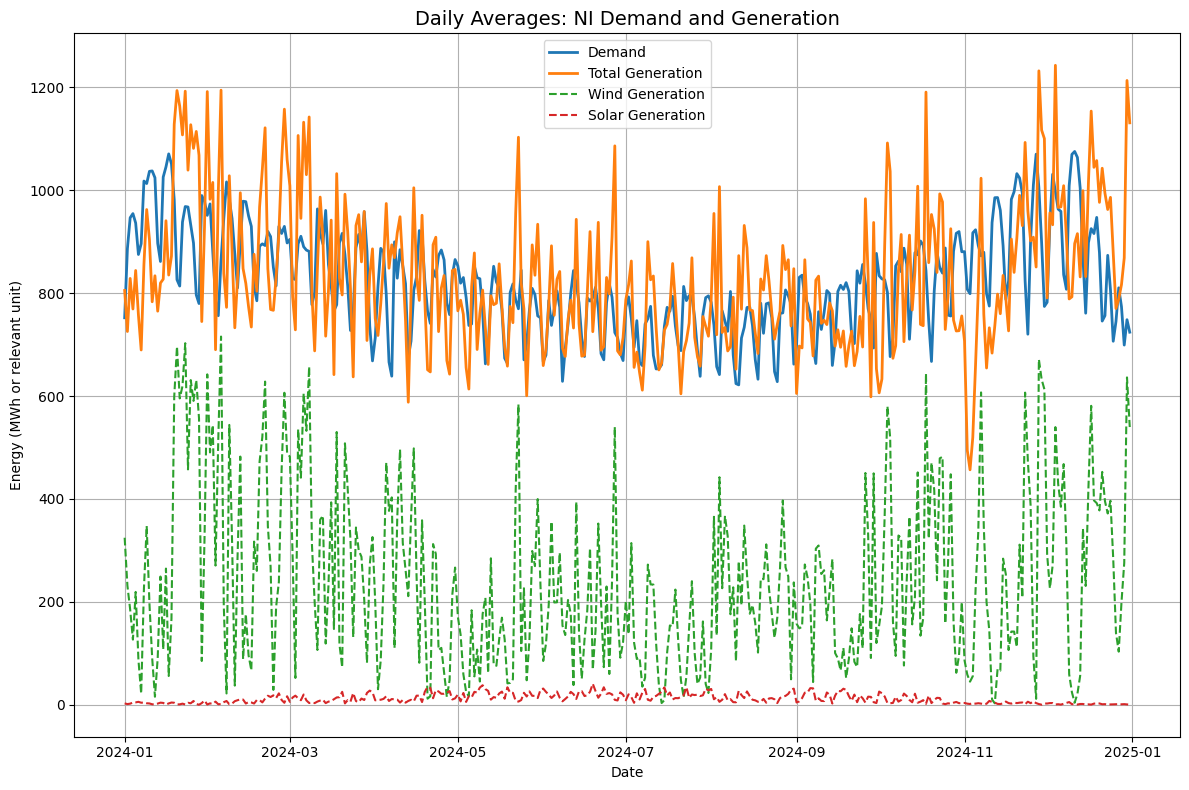

In [15]:
NI_daily_stats = df_full[['NI Demand','NI Generation', 'NI Wind Generation', 'NI Solar Generation']] # Copy relevant columns
NI_daily_stats = NI_daily_stats.resample('D').mean() # Resample to daily frequency and calculate mean

# plot all four time series plots
plt.figure(figsize=(12, 8))
plt.plot(NI_daily_stats.index, NI_daily_stats['NI Demand'], label='Demand', linewidth=2)
plt.plot(NI_daily_stats.index, NI_daily_stats['NI Generation'], label='Total Generation', linewidth=2)
plt.plot(NI_daily_stats.index, NI_daily_stats['NI Wind Generation'], label='Wind Generation', linestyle='--')
plt.plot(NI_daily_stats.index, NI_daily_stats['NI Solar Generation'], label='Solar Generation', linestyle='--')

# set plot title and labels
plt.title('Daily Averages: NI Demand and Generation', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Energy (MWh or relevant unit)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Qualitative Analysis of North Ireland(NI) Daily Averages:**

On average, North Ireland generates more than the demand. Furthermore, The demand stays relatively consistent throughout the year, fluctuating between roughly 600–1100 MWh daily, with no dramatic long-term upward or downward trend. Additionally, demand tends to be higher during winter months (start and end of the year) and slightly lower during summer time.

Northern ireland has occasional spikes in power generation with both the highest and lowest yield being caused by the spikes in wind generation. The Solar output is much lower overall staying near zero for most of the year except the small increases during summer time (Mid-year) 

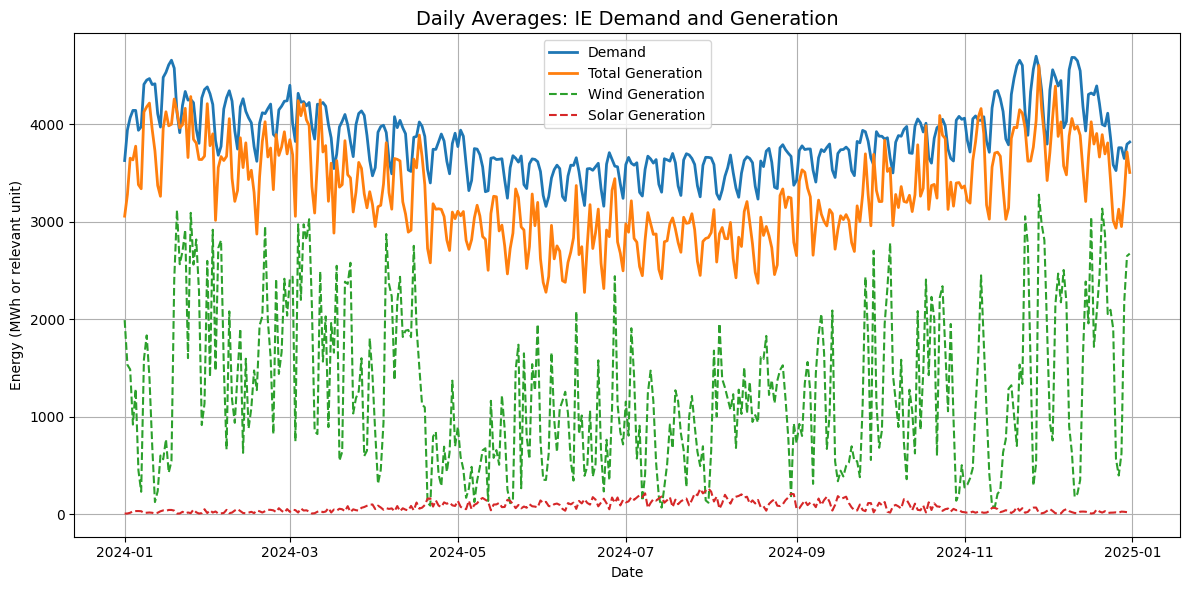

In [16]:
IE_daily_stats = df_full[['IE Demand','IE Generation', 'IE Wind Generation', 'IE Solar Generation']] # Copy relevant columns
IE_daily_stats = IE_daily_stats.resample('D').mean() # Resample to daily frequency and calculate mean

# plot all four time series plots   
plt.figure(figsize=(12, 6))
plt.plot(IE_daily_stats.index, IE_daily_stats['IE Demand'], label='Demand', linewidth=2)
plt.plot(IE_daily_stats.index, IE_daily_stats['IE Generation'], label='Total Generation', linewidth=2)
plt.plot(IE_daily_stats.index, IE_daily_stats['IE Wind Generation'], label='Wind Generation', linestyle='--')
plt.plot(IE_daily_stats.index, IE_daily_stats['IE Solar Generation'], label='Solar Generation', linestyle='--')

# set plot title and labels
plt.title('Daily Averages: IE Demand and Generation', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Energy (MWh or relevant unit)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Qualitative Analysis of Ireland(IE) Daily Averages:**

On average, Ireland has a higher daily demand that what it can generate.
The daily demand fluctuates between 3000 and 4500 MWh throughout the year while remaining relatively consistent without consisting an upward trend or a downward trend. Just like in Northern Ireland, Ireland has a higher demand for electricty during the winter periods (Start of year and end of year) with the highest peaks in demand occuring in the months of January and December. Additionally, Some noticeable dips in power generation occur in the middle of the year which corresponds to the lower yield from the wind generation output.
Solar output still remains much lower in magnitude as compared to other sources and peaking around the middle of the year where the days are longer implying more sunlight.

Finally, it is worth mentioning that wind energy generation in Ireland is almost tripple that of North Ireland.


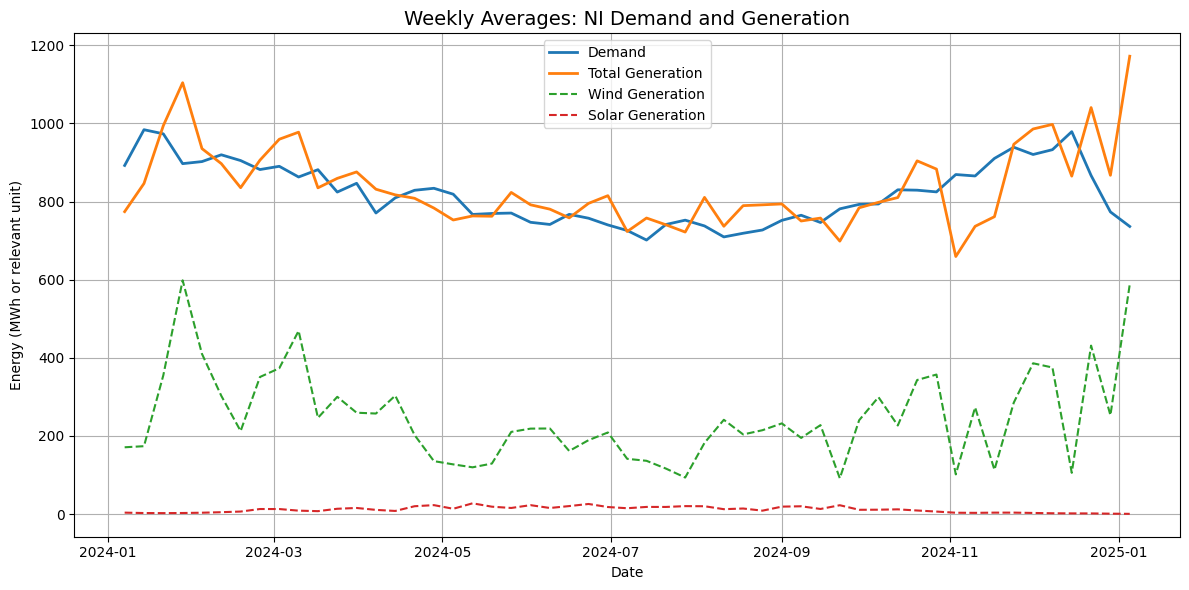

In [17]:
NI_weekly_stats = df_full[['NI Demand','NI Generation', 'NI Wind Generation', 'NI Solar Generation']] # Copy relevant columns
NI_weekly_stats = NI_weekly_stats.resample('W').mean() # Resample to weekly frequency and calculate mean

# Plot all four time series plots
plt.figure(figsize=(12, 6))
plt.plot(NI_weekly_stats.index, NI_weekly_stats['NI Demand'], label='Demand', linewidth=2)
plt.plot(NI_weekly_stats.index, NI_weekly_stats['NI Generation'], label='Total Generation', linewidth=2)
plt.plot(NI_weekly_stats.index, NI_weekly_stats['NI Wind Generation'], label='Wind Generation', linestyle='--')
plt.plot(NI_weekly_stats.index, NI_weekly_stats['NI Solar Generation'], label='Solar Generation', linestyle='--')

# set plot title and labels
plt.title('Weekly Averages: NI Demand and Generation', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Energy (MWh or relevant unit)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Qualitative Analysis of North Ireland(NI) Weekly Averages:**

During the winter periods, especially November, December, January and February, both demand and total generation reach their highest points of the year. Demand peaks at approximately 1000 MWh, showing the increased need for heating and lighting during colder months. This period also shows a higher yield for wind generation that rises to around 600 MWh which helps to meet the increased demand.
As the year enters summer a gradual dip in both demand and generation occurs. Demand falls to roughly 700 MWh, this could possiblby be due to higher temperatures and extended daylight hours that reduce heating and lighting needs. The total generation also displays a gradual decrease during this period of time, largely due to the reduction in wind speeds with wind generation dropping to around 150–200 MWh.

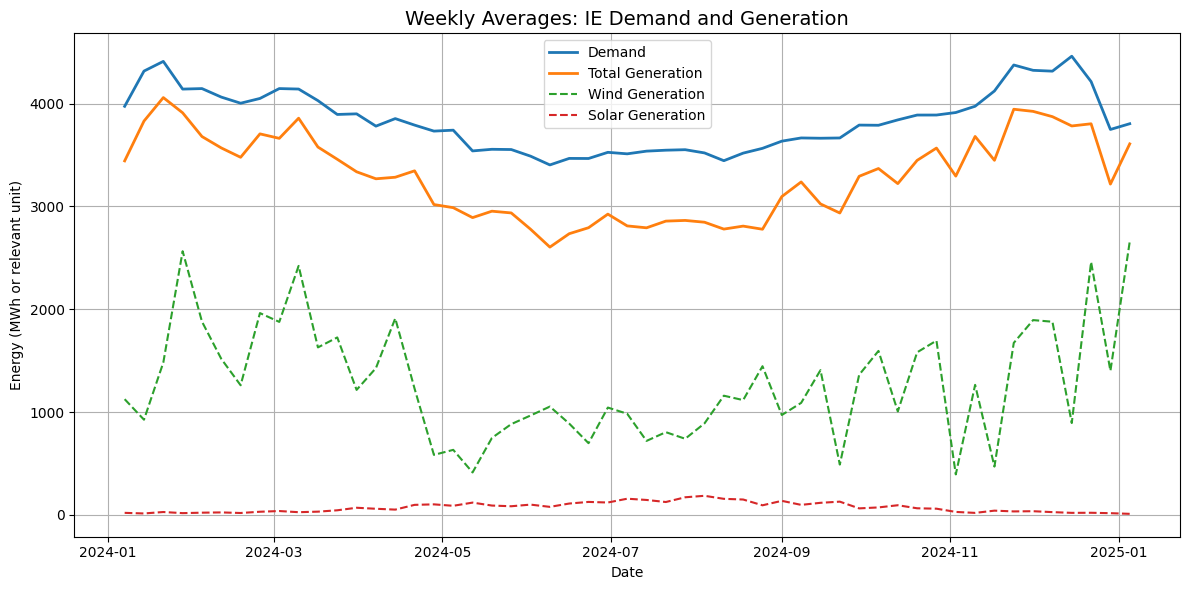

In [18]:
IE_weekly_stats = df_full[['IE Demand','IE Generation', 'IE Wind Generation', 'IE Solar Generation']] # Copy relevant columns
IE_weekly_stats = IE_weekly_stats.resample('W').mean() # Resample to weekly frequency and calculate mean

# plot all four time series plots
plt.figure(figsize=(12, 6))
plt.plot(IE_weekly_stats.index, IE_weekly_stats['IE Demand'], label='Demand', linewidth=2)
plt.plot(IE_weekly_stats.index, IE_weekly_stats['IE Generation'], label='Total Generation', linewidth=2)
plt.plot(IE_weekly_stats.index, IE_weekly_stats['IE Wind Generation'], label='Wind Generation', linestyle='--')
plt.plot(IE_weekly_stats.index, IE_weekly_stats['IE Solar Generation'], label='Solar Generation', linestyle='--')

# set plot title and labels
plt.title('Weekly Averages: IE Demand and Generation', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Energy (MWh or relevant unit)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Qualitative Analysis of Ireland(IE) Weekly Averages:**

It is worth noting that the weekly average demand for Ireland is always higher that their capacity for generation.
Both the demand and the generation are at their highest during the winter periods at the end of the year and at the beginning of the year. 
The demand and generation hit a plateau dip during the middle of the year with the demand dipping to an all time low of about 3500 MWh and the generation dipping as low as 2600 MWh. The trend in total power generation is directly correlated to the wind energy generation since wind energy accounts for almost 50% of the total generated energy.


## Question 4

#### **Autocorrelation Function (ACF) For IE Wind Generation**

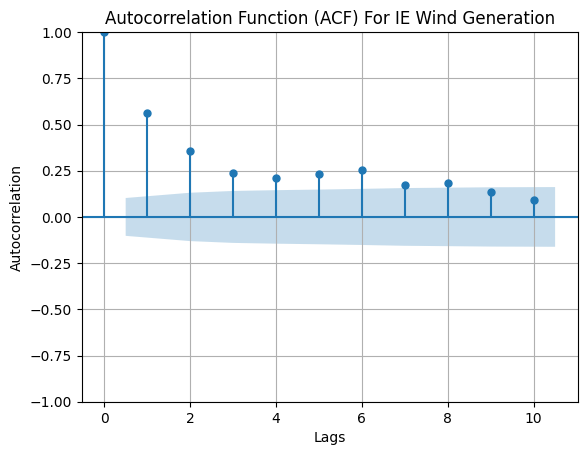

In [42]:
IE_wind_daily = IE_daily_stats.drop(columns=['IE Demand','IE Generation','IE Solar Generation']) #Drop other columns to isolate wind generation

plot_acf(IE_wind_daily, lags=10) #Plot ACF for IE Wind Generation with 10 lags

# set plot title and labels
plt.title('Autocorrelation Function (ACF) For IE Wind Generation')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid()

plt.show()

The autocorrelation pattern for IE Wind Generation reveals a short term dependency in the data. At lag 0, the autocorrelation is naturally 1, indicating perfect correlation with itself. The values at lag 1 and lag 2 remain significantly large, suggesting that the current wind generation is strongly influenced by the values from the previous one to two days. However, beyond lag 2, the autocorrelation values decline and fall within the confidence interval i.e below 0.25, indicating that the influence of past values diminishes quickly. This pattern suggests that while wind generation in Ireland exhibits short term persistence, it lacks long term memory, likely due to the variable nature of wind conditions.

#### **Autocorrelation Function (ACF) For IE Solar Generation**

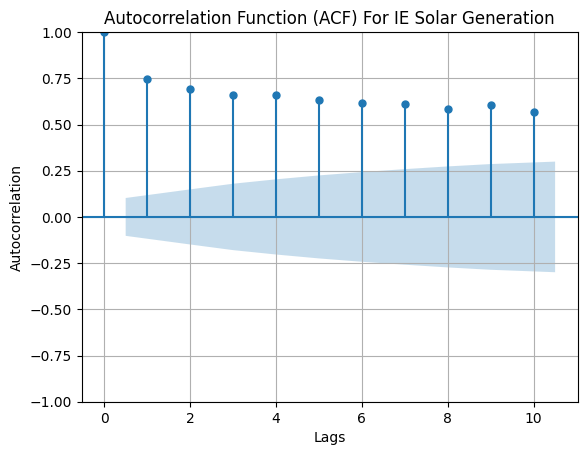

In [20]:
IE_solar_daily = IE_daily_stats.drop(columns=['IE Demand','IE Generation','IE Wind Generation']) #Drop other columns to isolate solar generation

plot_acf(IE_solar_daily, lags=10) #Plot ACF for IE Solar Generation with 10 lags

# set plot title and labels
plt.title('Autocorrelation Function (ACF) For IE Solar Generation')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid()

plt.show()

The autocorrelation pattern for IE Solar Generation indicates a strong and consistent dependency across multiple lags. As expected the autocorrelation at lag 0 is 1, representing perfect correlation with itself. However, what stands out is that the autocorrelation values remain significantly large i.e above 0.5 across all lags up to 10, and they lie outside the confidence interval bands. This suggests that solar generation in Ireland is not only influenced by immediate past values but also exhibits a stable pattern over time likely due to predictable daily solar cycles. Such a pattern is ideal for forecasting, as it implies that historical solar generation data can reliably inform future predictions.

**Autocorrelation Function (ACF) For NI Wind Generation**

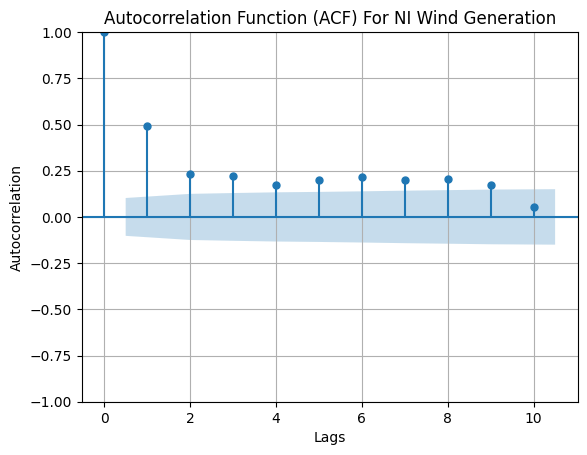

In [21]:
NI_wind_daily = NI_daily_stats.drop(columns=['NI Demand','NI Generation','NI Solar Generation']) #Drop other columns to isolate wind generation

plot_acf(NI_wind_daily, lags=10) #Plot ACF for NI Wind Generation with 10 lags

# set plot title and labels
plt.title('Autocorrelation Function (ACF) For NI Wind Generation')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid()

plt.show()

The autocorrelation pattern for NI Wind Generation shows a rapid decline in correlation strength after lag 1. While the autocorrelation at lag 0 is 1, as expected, the values for lag 2 and beyond drop below 0.25 and continue to decrease steadily. By lag 10, the autocorrelation is nearly zero, indicating that the influence of past wind generation values on current values diminishes quickly over time. This suggests that wind generation in Northern Ireland has low persistence and is likely driven by short term fluctuating weather conditions rather than long term patterns. As a result forecasting based on historical data may be limited to very short time horizons.

**Autocorrelation Function (ACF) For NI Solar Generation**

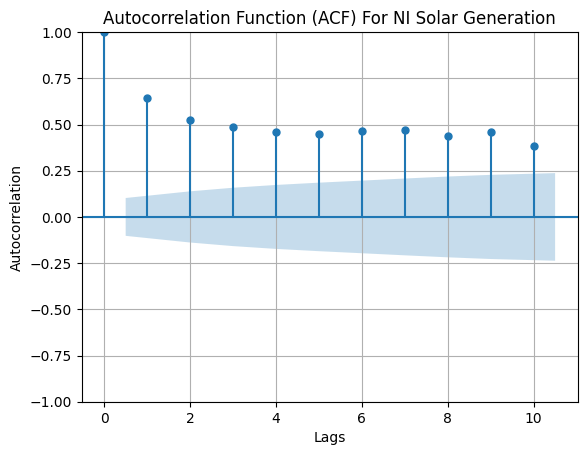

In [22]:
NI_solar_daily = NI_daily_stats.drop(columns=['NI Demand','NI Generation','NI Wind Generation']) #Drop other columns to isolate solar generation

plot_acf(NI_solar_daily, lags=10) #Plot ACF for NI Solar Generation with 10 lags

# set plot title and labels
plt.title('Autocorrelation Function (ACF) For NI Solar Generation')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid()

plt.show()

The autocorrelation pattern for NI Solar Generation demonstrates a strong and sustained dependency. As expected, the autocorrelation at lag 0 is 1, indicating perfect correlation with itself. Notably, from lag 2 onward, the autocorrelation values remain consistently around 0.5. This suggests that solar generation in Northern Ireland is influenced by its past values over multiple days, likely due to predictable daily solar cycles and stable weather patterns during daylight hours. However, the solar ACF for IE is much stronger than that of NI meaning that Ireland (IE) has more stable sunlight throughout the year.

## Question 5

**calculate the monthly averages of generation and demand for IE**

In [23]:
IE_monthly_stats = df_full[['IE Demand','IE Generation']] # Copy relevant columns
IE_monthly_stats = IE_monthly_stats.resample('ME').agg(['mean']) # Resample to monthly frequency and calculate mean


IE_monthly_stats.insert(0, ('Month', ''), [i+1 for i in range(len(IE_monthly_stats))]) #Insert month 
IE_monthly_stats['Month'] = IE_monthly_stats['Month'].apply(lambda x: calendar.month_name[x]) #Convert month number to month name

IE_monthly_stats.reset_index(drop=True, inplace=True) #reset index
IE_monthly_stats

,Month,IE Demand,IE Generation
,,mean,mean
0,January,4222.890017,3813.755874
1,February,4057.178035,3606.282680
2,March,3999.910128,3555.252053
3,April,3794.393826,3218.799882
4,May,3582.091492,2937.948212
5,June,3449.342531,2735.641278
6,July,3546.613498,2830.406109
7,August,3531.767154,2873.292540
8,September,3695.459003,3114.300823


**plot the monthly averages of generation and demand for IE**

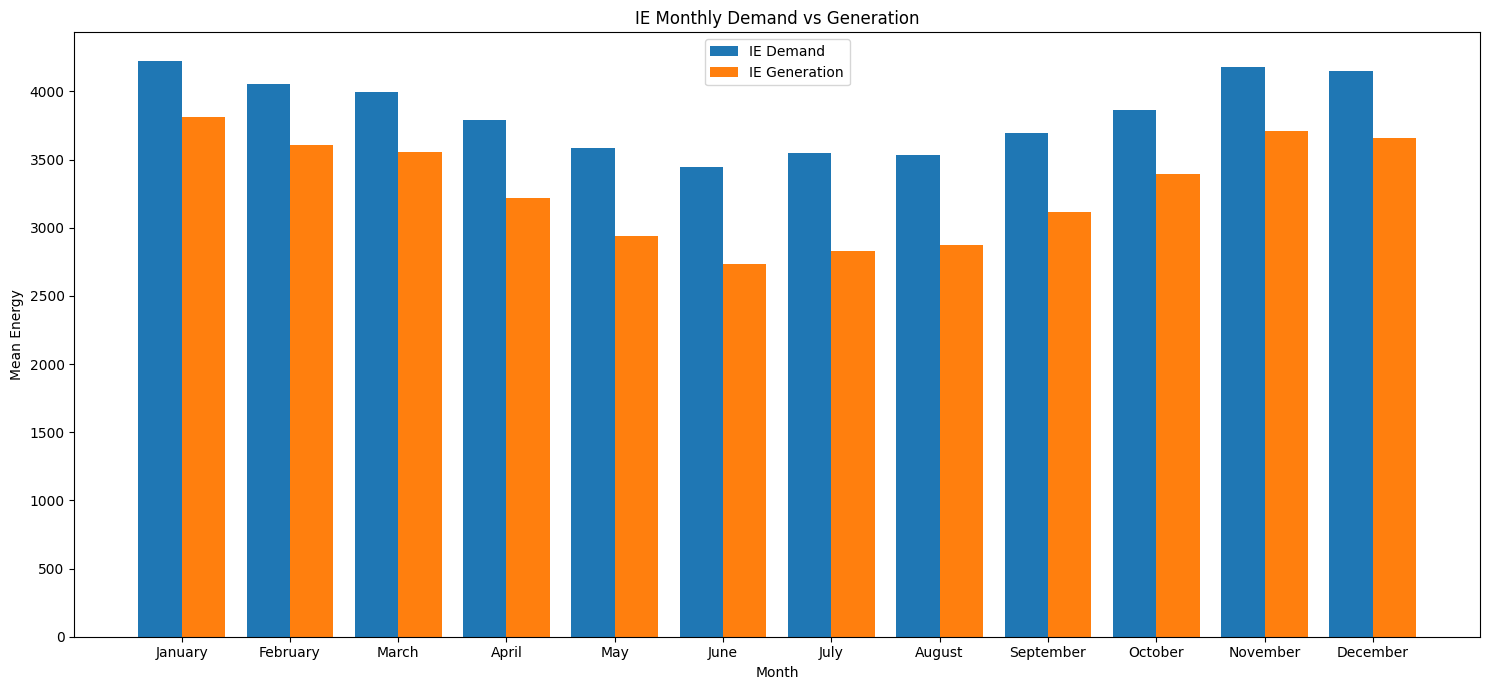

In [24]:
bar_width = 0.4

# Create positions for each group
x = range(len(IE_monthly_stats['Month'])) # X positions
x_demand = [i - bar_width / 2 for i in x] # X positions for demand bars
x_generation = [i + bar_width / 2 for i in x] # X positions for generation bars

# Plot IE Monthly Demand vs Generation
plt.figure(figsize=(15, 7))
plt.bar(x_demand, IE_monthly_stats['IE Demand']['mean'], width=bar_width, label='IE Demand')
plt.bar(x_generation, IE_monthly_stats['IE Generation']['mean'], width=bar_width, label='IE Generation')


plt.xticks(x, IE_monthly_stats['Month'])


plt.title('IE Monthly Demand vs Generation')
plt.xlabel('Month')
plt.ylabel('Mean Energy')
plt.legend()
plt.tight_layout()
plt.show()


Observations indicate that demand consistently exceeds generation throughout the year, resulting in a monthly shortfall. Demand peaks in January, November, and December at around 4000–4200 units, while generation is lowest from June to August, reflecting a seasonal dip in production. The largest gap between demand and generation occurs from May to September. Both demand and generation exhibit seasonal patterns with demand slightly lower in the summer months and higher in winter and generation following a similar but consistently lower trend.

**calculate the monthly averages of generation and demand for NI**

In [25]:
NI_monthly_stats = df_full[['NI Demand','NI Generation']] # Copy relevant columns
NI_monthly_stats = NI_monthly_stats.resample('ME').agg(['mean']) # Resample to monthly frequency and calculate mean


NI_monthly_stats.insert(0, ('Month', ''), [i+1 for i in range(len(NI_monthly_stats))]) #Insert month 
NI_monthly_stats['Month'] = NI_monthly_stats['Month'].apply(lambda x: calendar.month_name[x]) #Convert month number to month name

NI_monthly_stats.reset_index(drop=True, inplace=True) #reset index
NI_monthly_stats

,Month,NI Demand,NI Generation
,,mean,mean
0,January,940.092453,932.093070
1,February,897.000681,908.153517
2,March,853.700457,882.656130
3,April,813.307909,812.342889
4,May,776.130956,781.007030
5,June,746.247120,779.731959
6,July,735.135835,735.797871
7,August,724.788266,794.940191
8,September,772.409256,739.682739


**plot the monthly averages of generation and demand for NI**

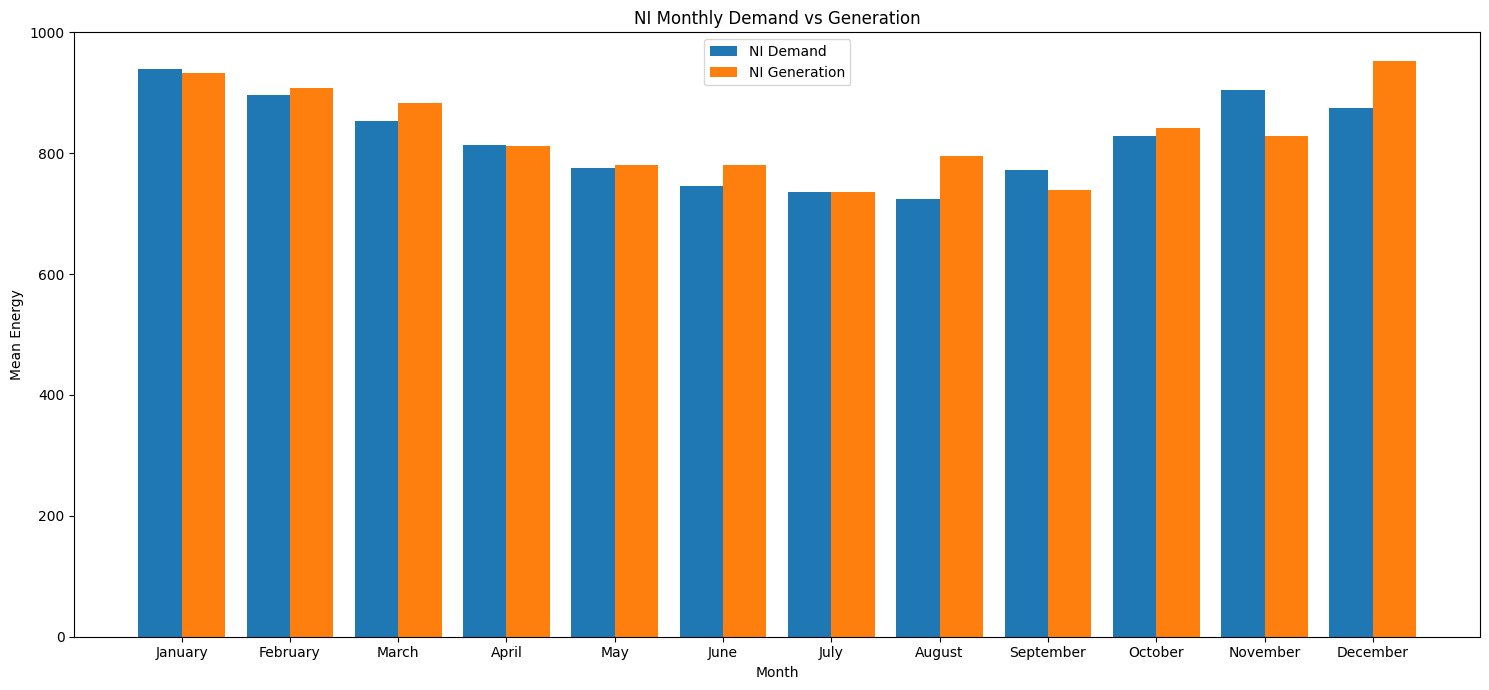

In [26]:
bar_width = 0.4

# Create positions for each group
x = range(len(NI_monthly_stats['Month'])) # X positions
x_demand = [i - bar_width / 2 for i in x] # X positions for demand bars
x_generation = [i + bar_width / 2 for i in x] # X positions for generation bars

# Plot NI Monthly Demand vs Generation
plt.figure(figsize=(15, 7))
plt.bar(x_demand, NI_monthly_stats['NI Demand']['mean'], width=bar_width, label='NI Demand')
plt.bar(x_generation, NI_monthly_stats['NI Generation']['mean'], width=bar_width, label='NI Generation')

# Set x-ticks
plt.xticks(x, NI_monthly_stats['Month'])


plt.title('NI Monthly Demand vs Generation')
plt.xlabel('Month')
plt.ylabel('Mean Energy')
plt.legend()
plt.tight_layout()
plt.show()

Overall, demand and generation show similar seasonal trends, but demand generally exceeds generation in most months. Demand reaches its highest levels in January, November, and December, while generation is relatively lower in the summer months, particularly from June to August. The largest gaps between demand and generation appear during late spring and summer, suggesting potential supply constraints. Both series exhibit seasonal variation, with demand peaking in winter and generation slightly lagging behind, indicating that generation does not fully match demand at any point in the year.

## Question 6

In [27]:

NI_hourly_stats = df_full[['NI Wind Generation', 'NI Solar Generation']] # Copy relevant columns    
NI_hourly_stats = NI_hourly_stats.resample('h').agg(['mean']) # Resample to hourly frequency and calculate mean
NI_hourly_stats = NI_hourly_stats.groupby(NI_hourly_stats.index.hour).mean() #Group by hour and calculate mean
NI_hourly_stats

,NI Wind Generation,NI Solar Generation
,mean,mean
DateTime,,
0,191.217907,0.052130
1,184.623177,0.052128
2,173.919798,0.052134
3,168.189448,0.052128
4,170.274204,0.052180
5,185.590421,0.153372
6,220.703078,1.040840
7,240.917031,3.871183


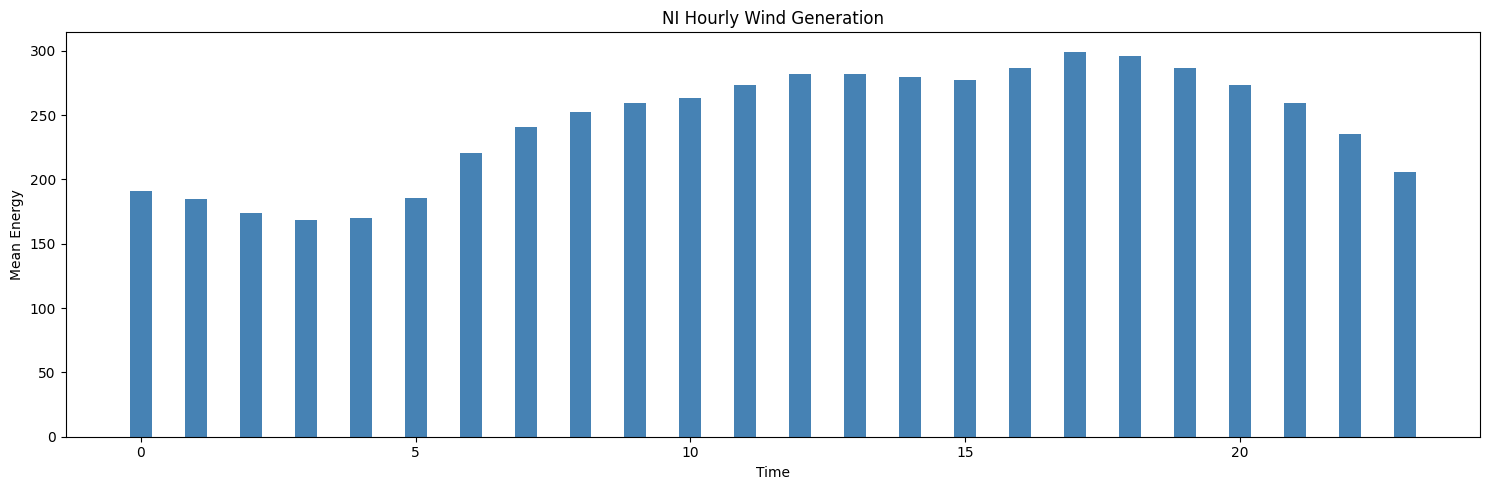

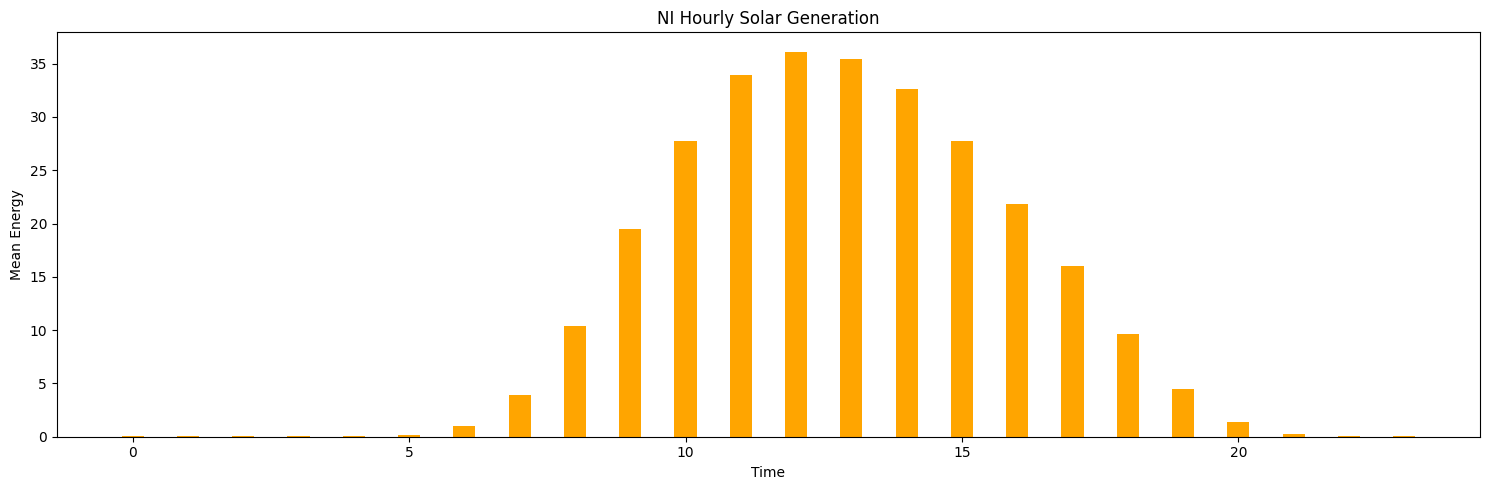

In [28]:
bar_width = 0.4 # Bar width
x = range(len(NI_hourly_stats)) # X positions

# Plot NI Wind Generation
plt.figure(figsize=(15, 5)) 
plt.bar(x, NI_hourly_stats['NI Wind Generation']['mean'], width=bar_width, color='steelblue')
plt.title('NI Hourly Wind Generation')
plt.xlabel('Time')
plt.ylabel('Mean Energy')
plt.tight_layout()
plt.show()

# Plot NI Solar Generation
plt.figure(figsize=(15, 5))
plt.bar(x, NI_hourly_stats['NI Solar Generation']['mean'], width=bar_width, color='orange')
plt.title('NI Hourly Solar Generation')
plt.xlabel('Time')
plt.ylabel('Mean Energy')
plt.tight_layout()
plt.show()

the first bar chart shows how wind energy production in Northern Ireland changes throughout the day. Wind generation remains active across all 24 hours, with lower output during the early morning (around 0–5 hours) and gradually increasing during the day. The highest levels occur in the afternoon (around 15–17 hours), reaching close to 300 units, before slightly declining in the evening. This pattern suggests that wind conditions strengthen during the day and weaken at night, making wind a consistent but variable renewable energy source that provides steady power even when solar generation is unavailable.

The second graph shows how solar energy production in Northern Ireland varies throughout the day. As expected, there is no generation during nighttime hours (0–5 and 19–23), while production begins to rise after sunrise. Solar output increases sharply from around 7 a.m., reaching its peak between 11 a.m. and 2 p.m., with mean energy levels of about 35–37 units. After this peak, generation gradually declines in the late afternoon as sunlight decreases, eventually returning to zero by evening. This clear bell-shaped pattern reflects the natural dependence of solar power on daylight intensity and sunlight availability.

## Question 7

In [29]:
IE_week_days_stats = df_full[['IE Demand', 'IE Generation']].copy() # Copy relevant columns

IE_week_days_stats['Weekday'] = IE_week_days_stats.index.day_name() # Extract day of week from datetime index

IE_week_days_stats = IE_week_days_stats.groupby('Weekday').mean() # Group by weekday and calculate mean
IE_week_days_stats = IE_week_days_stats.reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
) 

IE_week_days_stats

,IE Demand,IE Generation
Weekday,,
Monday,3860.687938,3316.142685
Tuesday,3953.806627,3407.433758
Wednesday,3966.219762,3447.232019
Thursday,3966.180571,3450.834704
Friday,3922.764113,3340.633746
Saturday,3653.664239,3069.126166
Sunday,3544.693179,2973.085435


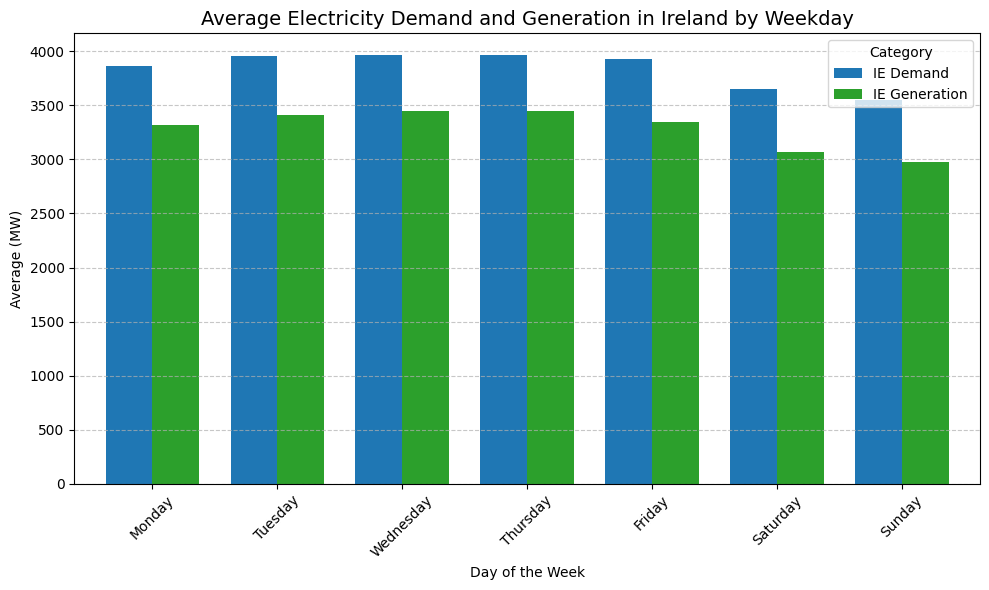

In [30]:
# Plotting
ax = IE_week_days_stats.plot( kind='bar', figsize=(10, 6), width=0.75, color=['tab:blue', 'tab:green'])

# Add titles and labels
plt.title('Average Electricity Demand and Generation in Ireland by Weekday', fontsize=14)
plt.xlabel('Day of the Week')
plt.ylabel('Average (MW)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Category')

plt.tight_layout()
plt.show()

The weekday averages show higher electricity demand from Monday to Friday and lower values during the weekend, consistent with typical work and industrial schedules. Generation closely follows demand to maintain grid balance. The slightly reduced weekend activity and variability in renewable output make the results intuitively reasonable.

## Question 8

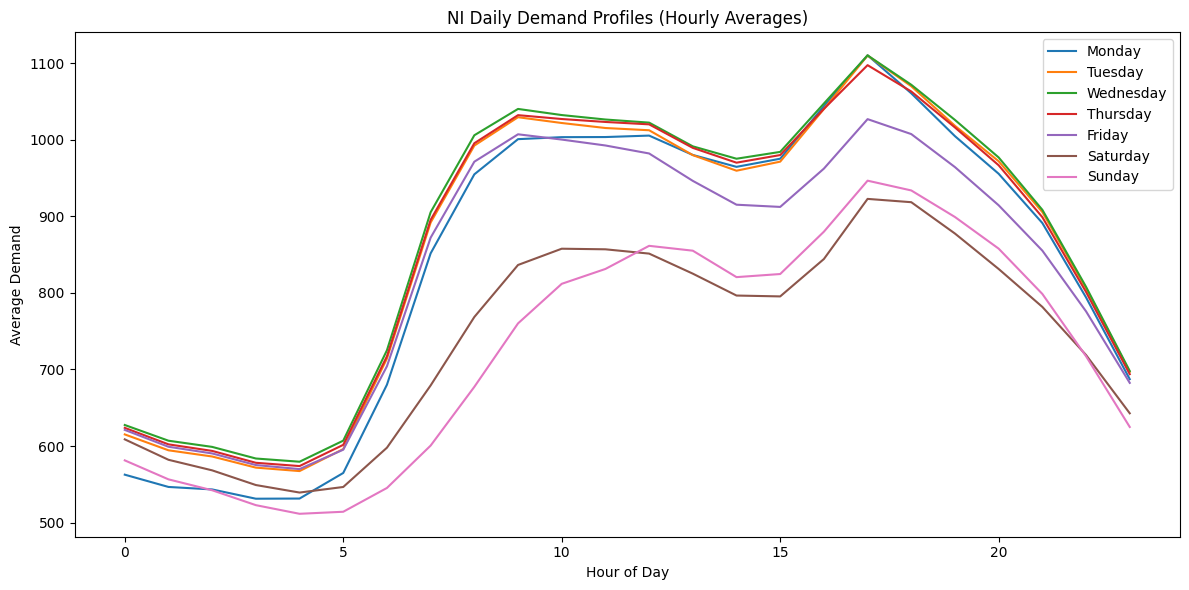

In [31]:

# Create a copy to preserve original data 
df_copy = df_full.copy()

df_copy.index = pd.to_datetime(df_copy.index) # Ensure index is in datetime format

# Extract day of week and hour from the index
df_copy['DayOfWeek'] = df_copy.index.day_name() # Extract day of week from datetime index
df_copy['Hour'] = df_copy.index.hour # Extract hour from datetime index

# Compute average hourly demand for each day of the week 
NI_profile = df_copy.groupby(['DayOfWeek', 'Hour'])['NI Demand'].mean().reset_index()
IE_profile = df_copy.groupby(['DayOfWeek', 'Hour'])['IE Demand'].mean().reset_index()

# Order days correctly 
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
NI_profile['DayOfWeek'] = pd.Categorical(NI_profile['DayOfWeek'], categories=day_order, ordered=True)
IE_profile['DayOfWeek'] = pd.Categorical(IE_profile['DayOfWeek'], categories=day_order, ordered=True)

# Plot NI Demand Profile 
plt.figure(figsize=(12, 6))
for day in day_order:
    day_data = NI_profile[NI_profile['DayOfWeek'] == day]
    plt.plot(day_data['Hour'], day_data['NI Demand'], label=day)
plt.title('NI Daily Demand Profiles (Hourly Averages)')
plt.xlabel('Hour of Day')
plt.ylabel('Average Demand')
plt.legend()
plt.tight_layout()
plt.show()



The graph shows the average hourly electricity demand in Northern Ireland for each day of the week. Demand is lowest during the early morning hours and peaks in the evening, reflecting typical daily activity patterns. Weekdays have consistently higher demand compared to weekends, with Saturday and Sunday showing noticeably lower levels, indicating reduced industrial and commercial activity.

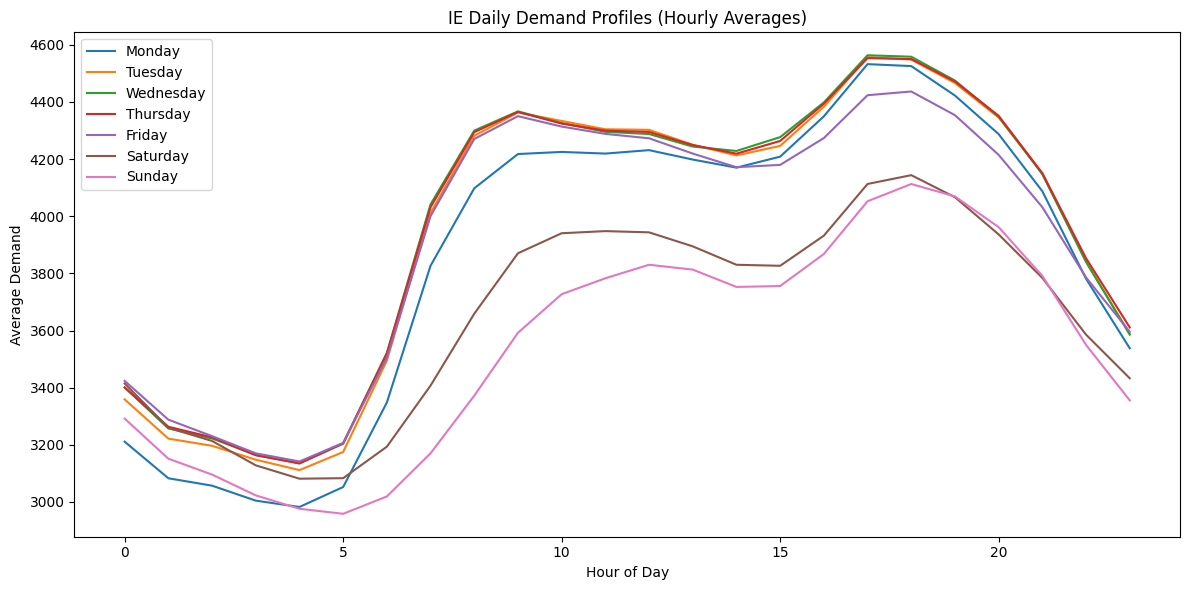

In [32]:
# Plot IE Demand Profile
plt.figure(figsize=(12, 6))
for day in day_order:
    day_data = IE_profile[IE_profile['DayOfWeek'] == day]
    plt.plot(day_data['Hour'], day_data['IE Demand'], label=day)
plt.title('IE Daily Demand Profiles (Hourly Averages)')
plt.xlabel('Hour of Day')
plt.ylabel('Average Demand')
plt.legend()
plt.tight_layout()
plt.show()

The above graph illustrates the average hourly electricity demand in Ireland (IE) for each day of the week. Demand is lowest in the early morning hours and rises sharply after 6:00 AM, peaking in the evening between 6:00 and 8:00 PM. Weekdays show higher and more consistent demand levels, while Saturday and Sunday exhibit noticeably lower demand throughout the day, reflecting reduced industrial and commercial activity during weekends.

## Question 9

**IE Demand Hypothesis testing**

In [33]:
# Separate weekdays and weekends for Ireland (IE)
weekend_days = ['Saturday', 'Sunday']
weekday_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Copy data
IE_data = df_full[['IE Demand']].copy()
IE_data['Weekday'] = IE_data.index.day_name()

# Split into weekday and weekend subsets
IE_weekday = IE_data[IE_data['Weekday'].isin(weekday_days)]
IE_weekend = IE_data[IE_data['Weekday'].isin(weekend_days)]

# Compute descriptive statistics
IE_summary = pd.DataFrame({
    'Category': ['Weekday', 'Weekend'],
    'Mean': [IE_weekday['IE Demand'].mean(), IE_weekend['IE Demand'].mean()],
    'Standard Deviation': [IE_weekday['IE Demand'].std(), IE_weekend['IE Demand'].std()],
    'Sample Size (n)': [IE_weekday['IE Demand'].count(), IE_weekend['IE Demand'].count()]
})

display(IE_summary)

,Category,Mean,Standard Deviation,Sample Size (n)
0,Weekday,3933.728104,604.812387,25152
1,Weekend,3599.178709,466.128281,9984


In [34]:
n1 = IE_summary.loc[IE_summary['Category'] == 'Weekday', 'Sample Size (n)'].values[0]
x1 = IE_summary.loc[IE_summary['Category'] == 'Weekday', 'Mean'].values[0]
s1 = IE_summary.loc[IE_summary['Category'] == 'Weekday', 'Standard Deviation'].values[0]

# Sample 2
n2 = IE_summary.loc[IE_summary['Category'] == 'Weekend', 'Sample Size (n)'].values[0]
x2 = IE_summary.loc[IE_summary['Category'] == 'Weekend', 'Mean'].values[0]
s2 = IE_summary.loc[IE_summary['Category'] == 'Weekend', 'Standard Deviation'].values[0]

# --- Hypothesis Test Parameters ---
# The hypothesized difference in means under the null hypothesis (H0: µ1 - µ2 = 0)
hypothesized_mean_difference = 0
# Significance level
alpha = 0.05

# Calculation of Z-statistic 
# Formula: Z = ((x1 - x2) - hypothesized_mean_difference) / sqrt((s1^2 / n1) + (s2^2 / n2))
se_diff = np.sqrt((s1**2 / n1) + (s2**2 / n2))
z_statistic = ((x1 - x2) - hypothesized_mean_difference) / se_diff

# Calculation of P-value
# For a two-tailed test, the p-value is 2 * P(Z > |z_statistic|)
p_value = 2 * (1 - norm.cdf(np.abs(z_statistic)))

# Display and Interpretation 
print(f"Z-statistic: {z_statistic:.4f}")
print(f"P-value: {p_value:.10f}")
print(f"Significance level (α): {alpha}\n")

if p_value < alpha:
    print("Conclusion: Reject the null hypothesis.")
    print('p_value < alpha')
    print("There is a statistically significant difference between the two sample means.")
else:
    print("Conclusion: Fail to reject the null hypothesis.")
    print("There is no statistically significant difference between the two sample means.")

Z-statistic: 55.5229
P-value: 0.0000000000
Significance level (α): 0.05

Conclusion: Reject the null hypothesis.
p_value < alpha
There is a statistically significant difference between the two sample means.


**NI Demand Hypothesis Testing**

In [35]:
weekend_days = ['Saturday', 'Sunday']
weekday_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Copy data
NI_data = df_full[['NI Demand']].copy()
NI_data['Weekday'] = NI_data.index.day_name()

# Split into weekday and weekend subsets
NI_weekday = NI_data[NI_data['Weekday'].isin(weekday_days)]
NI_weekend = NI_data[NI_data['Weekday'].isin(weekend_days)]

# Compute descriptive statistics
NI_summary = pd.DataFrame({
    'Category': ['Weekday', 'Weekend'],
    'Mean': [NI_weekday['NI Demand'].mean(), NI_weekend['NI Demand'].mean()],
    'Standard Deviation': [NI_weekday['NI Demand'].std(), NI_weekend['NI Demand'].std()],
    'Sample Size (n)': [NI_weekday['NI Demand'].count(), NI_weekend['NI Demand'].count()]
})

display(NI_summary)

,Category,Mean,Standard Deviation,Sample Size (n)
0,Weekday,856.506558,211.968597,25152
1,Weekend,734.793724,161.446578,9984


In [36]:
# Sample 1
n1 = NI_summary.loc[NI_summary['Category'] == 'Weekday', 'Sample Size (n)'].values[0]
x1 = NI_summary.loc[NI_summary['Category'] == 'Weekday', 'Mean'].values[0]
s1 = NI_summary.loc[NI_summary['Category'] == 'Weekday', 'Standard Deviation'].values[0]

# Sample 2
n2 = NI_summary.loc[NI_summary['Category'] == 'Weekend', 'Sample Size (n)'].values[0]
x2 = NI_summary.loc[NI_summary['Category'] == 'Weekend', 'Mean'].values[0]
s2 = NI_summary.loc[NI_summary['Category'] == 'Weekend', 'Standard Deviation'].values[0]

# Hypothesis Test Parameters
hypothesized_mean_difference = 0
alpha = 0.05

# Z-statistic
se_diff = np.sqrt((s1**2 / n1) + (s2**2 / n2))
z_statistic = ((x1 - x2) - hypothesized_mean_difference) / se_diff

# P-value
p_value = 2 * (1 - norm.cdf(np.abs(z_statistic)))

# Display and Interpretation 
print(f"Z-statistic: {z_statistic:.4f}")
print(f"P-value: {p_value:.10f}")
print(f"Significance level (α): {alpha}\n")

if p_value < alpha:
    print("Conclusion: Reject the null hypothesis.")
    print('p_value < alpha')
    print("There is a statistically significant difference between the two sample means.")
else:
    print("Conclusion: Fail to reject the null hypothesis.")
    print("There is no statistically significant difference between the two sample means.")

Z-statistic: 58.0438
P-value: 0.0000000000
Significance level (α): 0.05

Conclusion: Reject the null hypothesis.
p_value < alpha
There is a statistically significant difference between the two sample means.


**IE Solar Generation Hypothesis Testing**

In [37]:
# Separate weekdays and weekends for Ireland (IE)
weekend_days = ['Saturday', 'Sunday']
weekday_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Copy data
IE_solar = df_full[['IE Solar Generation']].copy()
IE_solar['Weekday'] = IE_solar.index.day_name()

# Split into weekday and weekend subsets
IE_solar_weekday = IE_solar[IE_solar['Weekday'].isin(weekday_days)]
IE_solar_weekend = IE_solar[IE_solar['Weekday'].isin(weekend_days)]

# Compute descriptive statistics
IE_solar_summary = pd.DataFrame({
    'Category': ['Weekday', 'Weekend'],
    'Mean': [IE_solar_weekday['IE Solar Generation'].mean(), IE_solar_weekend['IE Solar Generation'].mean()],
    'Standard Deviation': [IE_solar_weekday['IE Solar Generation'].std(), IE_solar_weekend['IE Solar Generation'].std()],
    'Sample Size (n)': [IE_solar_weekday['IE Solar Generation'].count(), IE_solar_weekend['IE Solar Generation'].count()]
})

display(IE_solar_summary)

,Category,Mean,Standard Deviation,Sample Size (n)
0,Weekday,75.357633,122.555099,25152
1,Weekend,74.194508,122.336196,9984


In [38]:
# Sample 1
n1 = IE_solar_summary.loc[IE_solar_summary['Category'] == 'Weekday', 'Sample Size (n)'].values[0]
x1 = IE_solar_summary.loc[IE_solar_summary['Category'] == 'Weekday', 'Mean'].values[0]
s1 = IE_solar_summary.loc[IE_solar_summary['Category'] == 'Weekday', 'Standard Deviation'].values[0]

# Sample 2
n2 = IE_solar_summary.loc[IE_solar_summary['Category'] == 'Weekend', 'Sample Size (n)'].values[0]
x2 = IE_solar_summary.loc[IE_solar_summary['Category'] == 'Weekend', 'Mean'].values[0]
s2 = IE_solar_summary.loc[IE_solar_summary['Category'] == 'Weekend', 'Standard Deviation'].values[0]

# Hypothesis Test Parameters
hypothesized_mean_difference = 0
alpha = 0.05

# Z-statistic
se_diff = np.sqrt((s1**2 / n1) + (s2**2 / n2))
z_statistic = ((x1 - x2) - hypothesized_mean_difference) / se_diff

# P-value
p_value = 2 * (1 - norm.cdf(np.abs(z_statistic)))

# Display and Interpretation 
print("Ireland (IE) Solar Generation")
print(f"Z-statistic: {z_statistic:.4f}")
print(f"P-value: {p_value:.10f}")
print(f"Significance level (α): {alpha}\n")

if p_value < alpha:
    print("Conclusion: Reject the null hypothesis.")
    print("There is a statistically significant difference between the two sample means.")
else:
    print("Conclusion: Fail to reject the null hypothesis.")
    print('p_value > alpha')
    print("There is no statistically significant difference between the two sample means.")

Ireland (IE) Solar Generation
Z-statistic: 0.8034
P-value: 0.4217639691
Significance level (α): 0.05

Conclusion: Fail to reject the null hypothesis.
p_value > alpha
There is no statistically significant difference between the two sample means.


**NI Solar Generation Hypothesis Testing**

In [39]:
# Separate weekdays and weekends for Northern Ireland (NI)
weekend_days = ['Saturday', 'Sunday']
weekday_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Copy data
NI_solar = df_full[['NI Solar Generation']].copy()
NI_solar['Weekday'] = NI_solar.index.day_name()

# Split into weekday and weekend subsets
NI_solar_weekday = NI_solar[NI_solar['Weekday'].isin(weekday_days)]
NI_solar_weekend = NI_solar[NI_solar['Weekday'].isin(weekend_days)]

# Compute descriptive statistics
NI_solar_summary = pd.DataFrame({
    'Category': ['Weekday', 'Weekend'],
    'Mean': [NI_solar_weekday['NI Solar Generation'].mean(), NI_solar_weekend['NI Solar Generation'].mean()],
    'Standard Deviation': [NI_solar_weekday['NI Solar Generation'].std(), NI_solar_weekend['NI Solar Generation'].std()],
    'Sample Size (n)': [NI_solar_weekday['NI Solar Generation'].count(), NI_solar_weekend['NI Solar Generation'].count()]
})

display(NI_solar_summary)


,Category,Mean,Standard Deviation,Sample Size (n)
0,Weekday,11.738742,20.205933,25152
1,Weekend,11.874835,21.099053,9984


In [40]:
# Sample 1
n1 = NI_solar_summary.loc[NI_solar_summary['Category'] == 'Weekday', 'Sample Size (n)'].values[0]
x1 = NI_solar_summary.loc[NI_solar_summary['Category'] == 'Weekday', 'Mean'].values[0]
s1 = NI_solar_summary.loc[NI_solar_summary['Category'] == 'Weekday', 'Standard Deviation'].values[0]

# Sample 2
n2 = NI_solar_summary.loc[NI_solar_summary['Category'] == 'Weekend', 'Sample Size (n)'].values[0]
x2 = NI_solar_summary.loc[NI_solar_summary['Category'] == 'Weekend', 'Mean'].values[0]
s2 = NI_solar_summary.loc[NI_solar_summary['Category'] == 'Weekend', 'Standard Deviation'].values[0]

# --- Hypothesis Test Parameters ---
hypothesized_mean_difference = 0
alpha = 0.05

# Z-statistic
se_diff = np.sqrt((s1**2 / n1) + (s2**2 / n2))
z_statistic = ((x1 - x2) - hypothesized_mean_difference) / se_diff

# P-value
p_value = 2 * (1 - norm.cdf(np.abs(z_statistic)))

# Display and Interpretation 
print("Northern Ireland (NI) Solar Generation")
print(f"Z-statistic: {z_statistic:.4f}")
print(f"P-value: {p_value:.10f}")
print(f"Significance level (α): {alpha}\n")

if p_value < alpha:
    print("Conclusion: Reject the null hypothesis.")
    print("There is a statistically significant difference between the two sample means.")
else:
    print("Conclusion: Fail to reject the null hypothesis.")
    print('p_value > alpha')
    print("There is no statistically significant difference between the two sample means.")

Northern Ireland (NI) Solar Generation
Z-statistic: -0.5518
P-value: 0.5810618162
Significance level (α): 0.05

Conclusion: Fail to reject the null hypothesis.
p_value > alpha
There is no statistically significant difference between the two sample means.


## Question 10

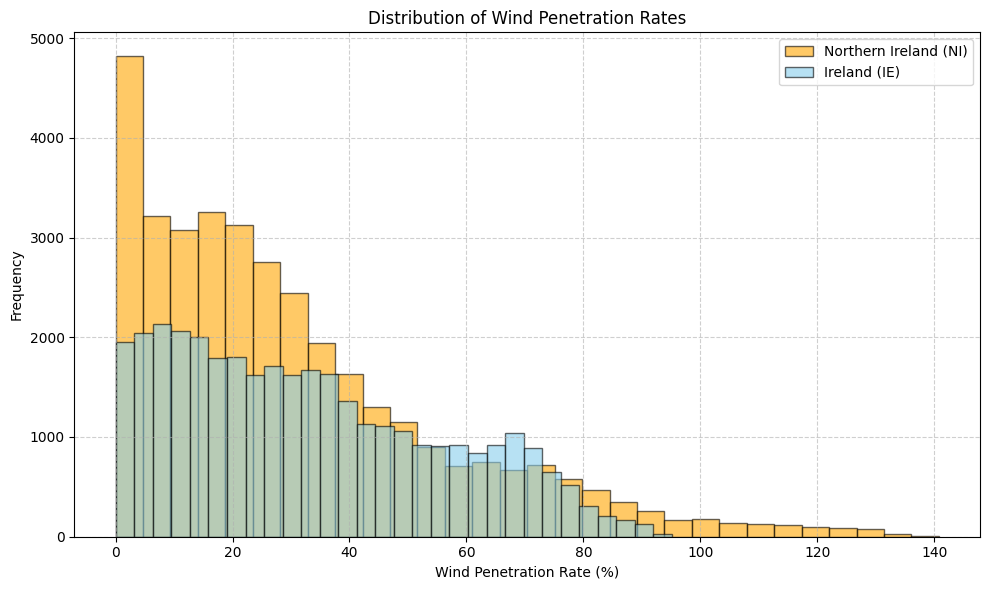

In [44]:
plt.figure(figsize=(10, 6))

plt.hist(df_full['NI Wind Penetration (%)'], bins=30, alpha=0.6, color='orange', label='Northern Ireland (NI)', edgecolor='black')
plt.hist(df_full['IE Wind Penetration (%)'], bins=30, alpha=0.6, color='skyblue', label='Ireland (IE)', edgecolor='black')

plt.title('Distribution of Wind Penetration Rates')
plt.xlabel('Wind Penetration Rate (%)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The graph shows the distribution of wind penetration rates for Northern Ireland (NI) and Ireland (IE). Both regions exhibit a right-skewed distribution, indicating that lower penetration rates occur more frequently. Northern Ireland’s curve peaks slightly higher at lower penetration values, suggesting that wind contributes a smaller share of total demand more often. In contrast, Ireland’s distribution extends further to the right, showing higher variability and more frequent occurrences of elevated penetration levels. Overall, this suggests that Ireland achieves higher wind integration into its electricity supply compared to Northern Ireland.